Rohan Dayal

rohan.dayal@columbia.edu



Research Question/Objective 1: To measure the proportion of Reddit posts posted between March and May 2020 on the Nursing Subreddit that discussed the availability of PPE resources such as masks, gowns, faceshields, discussed the procedures being followed for handling COVID-19 at hospitals, and  the availability of COVID-19 tests for patients. 

Research Question/Objective 2: To understand whether at some point during the March 16th-May 11th time period, the intensity of negative sentiment peaked at a certain date by plotting the negative sentiment intensity against time. Reddit posts posted between March and May 2020 on the Nursing Subreddit that discussed the availability of PPE resources such as masks, gowns, faceshields, discussed the procedures being followed for handling COVID-19 at hospitals, and  the availability of COVID-19 tests for patients. 

Research Question/Objective 3: To determine which of the searchkeys appeared most frequently in Reddit posts from the Nursing subreddit through using a dictionary model.

Research Question/Objective 4: To measure the total most commonly used words from the posts collected that include words from the searchkeys list, especially determining the words in these which were **not included in the searchkeys list**. Note that the methodology used here will differ from that in objective 3 and will use the Counter method from Collections library. 

Below is my program to collect the data using the Pushshift PRAW API from the Nursing Subreddit


In [ ]:
#Rohan Dayal

#!pip install praw
#!pip install nltk
import praw
import pandas as pd 
from datetime import datetime
import requests
import time
import re
#from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Reddit User information
agent = "unix:lionDataScraper:v1 (by /u/nlpScraperLion)"

#Reddit user information
reddit = praw.Reddit(client_id="########", client_secret="#################", user_agent=agent)

nurstexts=[]  #list to store each of the Reddit posts collected

#searchkeys list with all of the keywords pertaining to availability of resources for COVID-19
#Note that some words have .* on them because they are often compound words such as facemask, or protective-equipment, or face-shield
#searchkeys = ["face",".*mask.*", "PPE", ".*gowns.*", ".*gloves.*", "shortages", ".*equipment", ".*shield", "protocols", "supply","supplies", ".*test.*"]
subreddit = "nursing"

#List of UNIX Timestamps so data could be collected twice a week from March 16th, 2020 to May 11th, 2020
weektimestamps = [1584316800,1584921600,1589587200,1586131200,1586736000,1587340800,1587945600,1588550400,1589155200]""",(1584316800+1584921600)/2.0,
(1584921600+1589587200)/2.0,(1589587200+1586131200)/2.0,(1586131200+1586736000)/2.0,(1586736000+1587340800)/2.0,(1587340800+1587945600)/2.0,
(1587945600+1588550400)/2.0,(1588550400+1589155200)/2.0]"""
weektimestamps.sort() #Sort the list of timestamps since last 8 entries were for finding middle of the week values

def submissions_pushshift_praw(extra_query,reddit,subreddit, start=None, end=None, limit=100):
    #Function builds upon work done by Reddit user u/kungming2 on how to connect to the Pushshift PRAW API
    #See user's original post here: https://www.reddit.com/r/redditdev/comments/8r756k/a_dropin_pushshift_replacement_for_the_deprecated/
    """
    A simple function that returns a list of PRAW submission objects during a particular period from a defined sub.
    This function serves as a replacement for the now deprecated PRAW `submissions()` method.
    
    :param subreddit: A subreddit name to fetch submissions from.
    :param start: A Unix time integer. Posts fetched will be AFTER this time. (default: None)
    :param end: A Unix time integer. Posts fetched will be BEFORE this time. (default: None)
    :param limit: There needs to be a defined limit of results (default: 100), or Pushshift will return only 25.
    :param extra_query: A query string is optional. If an extra_query string is not supplied, 
                        the function will just grab everything from the defined time period. (default: empty string)
    
    Submissions are yielded newest first.
    """
    matching_praw_submissions = []
    
    # Default time values if none are defined (credit to u/bboe's PRAW `submissions()` for this section)
    utc_offset = 28800
    now = int(time.time())
    start = max(int(start) + utc_offset if start else 0, 0)
    end = min(int(end) if end else now, now) + utc_offset
   
    search_link = ('https://api.pushshift.io/reddit/submission/search/'
                   '?subreddit={}&after={}&before={}&sort_type=score&sort=asc&limit={}&q={}')
    search_link = search_link.format(subreddit, start, end, limit, extra_query)
    
    # Get the data from Pushshift as JSON.
    retrieved_data = requests.get(search_link)
    returned_submissions = retrieved_data.json()['data']
    
    # Iterate over the returned submissions to convert them to PRAW submission objects.
    for submission in returned_submissions:
        
        # Take the ID, fetch the PRAW submission object, and append to our list
        praw_submission = reddit.submission(id=submission['id'])
        matching_praw_submissions.append(praw_submission)
     
    # Return all PRAW submissions that were obtained.
    return matching_praw_submissions

r=""#Empty because initially seeking to collect posts of any category from the Subreddit
for i in range(len(weektimestamps)-1):#Goes through each of the timestamp periods of two dates, until 
    #len-1 bc method uses i+1 for bound date
    #submissions_pushshift_praw method used to interact with the pushshift praw API so that previous Reddit data can be scraped
    for submission in submissions_pushshift_praw(r,reddit,subreddit, start =weektimestamps[i], end=weektimestamps[i+1]):
        curpost=[]#list for current posting
        curpost.append(submission.id)#unique ID for the Reddit post and appended
        curpost.append(submission.author)#author name for the Reddit post and appended
        ts = int(submission.created_utc)#utc when Reddit post was posted
        curpost.append(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))#formatted utc to datetime and appended
        curpost.append(submission.selftext)#text for Reddit and appended
        
        nurstexts.append(curpost)#appending the list for the current Subreddit post to the list of all the Subreddit posts

print("Data has been collected")
mydf = pd.DataFrame(nurstexts) #dataframe to store all the posts collected without filtration

mydf = mydf.rename(columns={0:'id',1:'user',2:'date',3:'text'})

mydf = mydf.sort_values(by='date')
mydf = mydf[mydf.user.notnull()]  #filter dataframe to only include posts by users that were not deleted

mydf = mydf.reset_index(drop=True)
print(mydf)

#mydf.to_csv('redditData.csv') #convert dataframe to csv file and save
#dfwords = mydf[mydf['text'].str.contains("|".join(searchkeys))]#filter dataframe to have entries 
#that only contain the elements listed in searchkeys list
#dfwords = dfwords.reset_index(drop=True)
#print(dfwords)
#pctWKeyword = (float(len(dfwords.index))/(float(len(mydf.index))))*100.0  #Calculation to determine the percentage of the posts
#containing at least one of the elements in searchkeys
#print("Percentage of posts containing element from searchkeys list: ",pctWKeyword)





Data has been collected
          id  ...                                               text
0     fjhjsj  ...  As the title states, I was hoping to get an id...
1     fjhqf6  ...                                          [removed]
2     fjiwsw  ...  To aerosol Ativan through the USA to calm the ...
3     fjk2gp  ...                                                   
4     fjk6o9  ...                                                   
...      ...  ...                                                ...
1031  gkg13y  ...  My wife took the exam today, completed it in 6...
1032  gkk04j  ...  Hello, I am an LPN with my Bachelor of Science...
1033  gkkfcl  ...                                          [removed]
1034  gklz5l  ...  Hello, nurses!\nI’m a new grad that recently a...
1035  gkpch7  ...  So I am awaiting my test results after having ...

[1036 rows x 4 columns]
         id  ...                                               text
0    fjhjsj  ...  As the title states, I was hoping to 

Below is my code to conduct analysis of the collected data. Code will determine the percentage of posts which contained at least one key from the searchkeys list. Program then analyzes the sentiment of the text for the Reddit posts which discussed keywords pertinent to COVID supplies as listed in searchkeys list using the Natural Language Toolkit Library's SentimentIntensityAnalyzer. A plot of the com

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Percentage of Subreddit posts containing one of the elements from searchkeys list:  11.293436293436294


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to b

         id                  user                date  ...    neg    neu    pos
0    fjhjsj               al_baba 2020-03-16 08:16:41  ...  0.113   0.76  0.126
1    fk56zw            wilburtino 2020-03-17 13:24:54  ...  0.082  0.744  0.175
2    fkjtrg          theparamurse 2020-03-18 04:38:35  ...  0.091  0.865  0.044
3    fkrwrv                alumrn 2020-03-18 16:03:36  ...  0.033  0.779  0.188
4    fkxu45           MrsWrinkles 2020-03-18 21:43:47  ...  0.011  0.896  0.093
..      ...                   ...                 ...  ...    ...    ...    ...
112  gh7o6a             Bexterity 2020-05-10 19:22:50  ...  0.027  0.929  0.045
113  gheiym          Catielady112 2020-05-11 01:56:47  ...      0  0.804  0.196
114  gj7j0z         thatgirlthot3 2020-05-13 20:53:03  ...  0.061  0.817  0.122
115  gkk04j  BustyNBootyFullNurse 2020-05-15 23:28:00  ...      0  0.848  0.152
116  gkpch7              awhoogaa 2020-05-16 05:32:21  ...  0.107   0.78  0.113

[117 rows x 8 columns]
Average compound

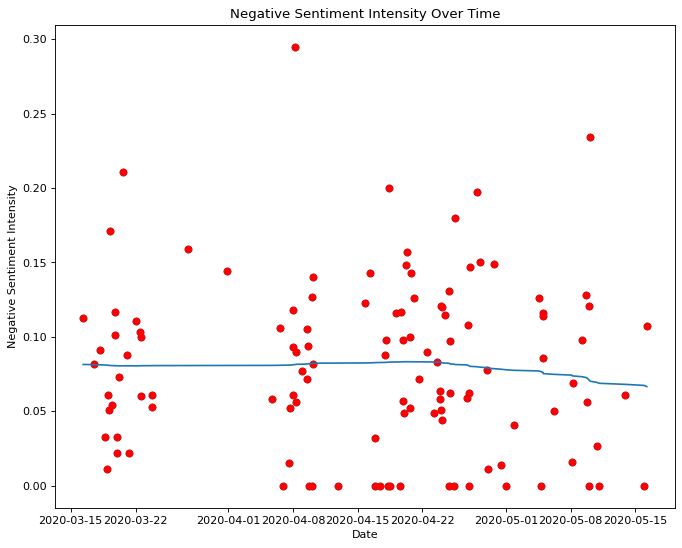

In [ ]:
#Rohan Ojasvi Dayal
#uni: rod2105
#Professors Poliak and Dreisbach NLP Lab Project

import praw
import pandas as pd 
from datetime import datetime
import requests
import time
import re
import numpy as np
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt 
from collections import Counter



df = pd.read_csv('redditData.csv', index_col=0) #Read in collected data from the data collection
df['text'] = df['text'].fillna('')#fill cells in dataframe that contain NaN with empty string
df.date=pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S.%f')#format date column to proper pandas datetime

#searchkeys list with all of the keywords pertaining to availability of resources for COVID-19
#Note that some words have .* on them because they are often compound words such as facemask, or protective-equipment, or face-shield
searchkeys = ["face",".*mask.*", "PPE", ".*gowns.*", ".*gloves.*", "shortages", ".*equipment", ".*shield", "protocols", "supply","supplies", ".*test.*"]
#create a dictionary to count the frequency of each of the searchkeys in the list of Reddit posts. The value for each key
#is initialized to zero to start
searchdict = dict.fromkeys(searchkeys,0)
#filters dataframe to contain only posts with one of the keywords included. 
dfwords = df[df['text'].str.contains("|".join(searchkeys))]
dfwords = dfwords.reset_index(drop=True)
#Calculation of percentage of posts that contain at least one of the elements in searchkeys
pctWKeyword = (float(len(dfwords.index))/(float(len(df.index))))*100.0
print("Percentage of Subreddit posts containing one of the elements from searchkeys list: ",pctWKeyword)
#initialize SentimentIntensityAnalyzer object from the NLTK library
sid = SentimentIntensityAnalyzer()
dfwords['compound'] = pd.Series(float)  #create column in dfwords dataframe for compound sentiment intensity score
dfwords['neg'] = pd.Series(float) #create column in dfwords dataframe for negative sentiment intensity score
dfwords['neu']=pd.Series(float) #create column in dfwords dataframe for neutral sentiment intensity score
dfwords['pos']=pd.Series(float) #create column in dfwords dataframe for positive sentiment intensity score
for ind in dfwords.index:#iterate through each of the reddit postings
    ss = sid.polarity_scores(dfwords['text'][ind])#ss is now a dictionary with the sentiment scores
    dfwords['compound'][ind]=ss['compound']#compound SI score
    dfwords['neg'][ind] = ss['neg']#negative SI score
    dfwords['neu'][ind] = ss['neu']#neutral SI score
    dfwords['pos'][ind] = ss['pos']#positive SI score
    for key in searchkeys:#For loop to determine count of each of the searchkeys words
      tempkey = key
      if(tempkey[0:2]=='.*'):#edit tempkey to remove any .* at the beginning of the string
        tempkey = tempkey[2:]
      if(tempkey[len(tempkey)-2:]=='.*'):#edit tempkey to remove any .* at the end of the string
        tempkey = tempkey[:len(tempkey)-2]
      searchdict[key]+=dfwords['text'][ind].count(tempkey)#add the count for each of the keywords in each of posts

print(dfwords)
averagecompound = dfwords['compound'].mean()#calculate average compound SI score
averageneg = dfwords['neg'].mean()#calculate average negative compound SI score
averageneu = dfwords['neu'].mean()#calculate average neutral compound SI score
averagepos = dfwords['pos'].mean()#calculate average positive
print("Average compound ",averagecompound)
print("Average neg ",averageneg)
print("Average neu ",averageneu)
print("Average pos ",averagepos)
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k') #enlarge size of plot 
#Plot the values for negative sentiment intensity over time (date values)
#Fit a 
y_axis = list(dfwords['neg'])
x_values = np.linspace(0,1,len(dfwords["neg"]))
x_values = x_values.astype(np.float64)
plt.scatter(dfwords['date'], dfwords['neg'])
degree=3

coefficients = np.polyfit(x_values,y_axis,degree)
poly_eqn = np.poly1d(coefficients)
y_hat = poly_eqn(x_values)

plt.plot(dfwords['date'], dfwords['neg'], "ro")
plt.plot(dfwords[ "date"],y_hat)
plt.title('Negative Sentiment Intensity Over Time')
plt.ylabel('Negative Sentiment Intensity')
plt.xlabel('Date')


wordfreqdf = pd.DataFrame.from_dict(searchdict,orient='index',columns=['Total Count'])
print(wordfreqdf)


#Now we are using the Counter method to determine the most popular words in all of the posts that contain the keywords
#NOTE: Note that this method does not account for a post
#which has typing errors such as neglecting to put a space between words or for compound words. 
#This may result in noticeable difference in the count for certain keywords
removewords = nltk.corpus.stopwords.words('english')#take common stopwords provided by the NLTK library and use to filter out
topwords = " ".join(dfwords["text"].str.lower()).split()#take all the words in all of the posts and make each word into its own element in 
#a topwords list. Ensures that all words made into lowercase
extrabadwords = ['i','get','i’m','know','like',"i'm"]#were not filtered out by nltk corpus but determined to be unnecessary 
#for inclusion in anlaysis
filtertop = [x for x in topwords if x not in  removewords and extrabadwords]  #generate filtertop list which includes all words from
#topwords that are not also elements in the removewords list


topwords = Counter(filtertop).most_common(50)#Generates list of the 100 most commonly used words
for i in topwords:
  print(i)





```
# This is formatted as code
```

**Preliminary Findings**


Objective 1: Based on the sample of Reddit posts collected (1035), it was found that the percentage of posts which contained at least one of the keywords found in the searchkeys list was **11.293436293436294%**. Since this is a sufficiently large sample size, we can use the z-proportion confidence interval formula to find a 99% confidence interval for the true value of the proportion of Reddit posts which included at least one of the keywords. The formula is:
# Formula below
$\hat{p} ± z^*  \sqrt{\frac{\hat{p}(1-\hat{p})}{n}}$

We can calculate this to be 0.112934±((2.333)((0.112934)(1-0.112934)/1035))^0.5

This leads to the bounds: (0.0890,0.1407) for the true proportion of reddit posts that contain at least one of the keywords.


Objective 2: Based on analsis of the graph, there is an increase in posts with stronger negative sentiment intensity between April 8th and April 22nd in comparison to before and after those two dates. This increase is very slight, however, and is accompanied by a general increase in the number of posts during that time period. However, we can observe that the negative sentiment intensity peaked between April 15th and April 22nd.

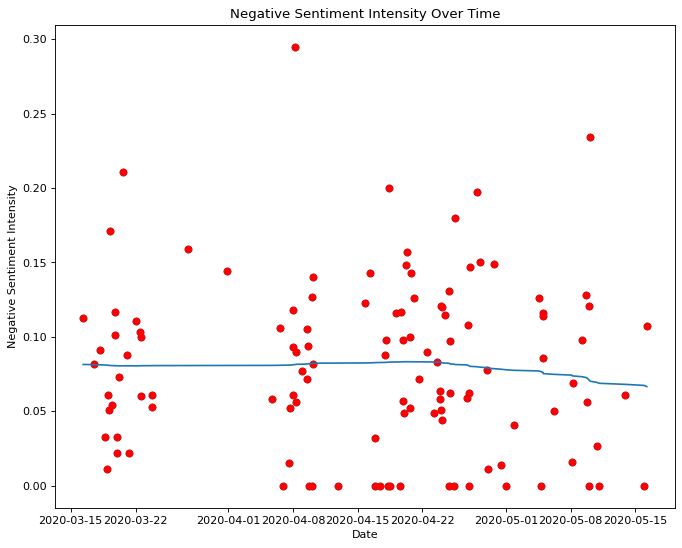

Objective 3: Based on the dictionary method I created, the most popular words from the searchkeys dictionary were any word which included test as a substring (including test itself), PPE, and any word that contained mask as a substring (including mask itself).


```
# This is formatted as code
             Total Count
face                  23
.*mask.*              66
PPE                   66
.*gowns.*              6
.*gloves.*             5
shortages              1
.*equipment            6
.*shield               7
protocols              6
supply                 5
supplies               8
.*test.*              78
```



**Objective 4**: The collections method yielded the following list for the top 50 words found in the dataframe of posts with at least one of the searchkeys keywords. Note that this method does not account for a post which has typing errors such as neglecting to put a space between words. This methodology also does not account for any compound words such as faceshield being included with shield, or facemask being included with mask, or masks instead of masks or tests instead of test. This resulted in some slightly different counts for words such as PPE and test. This method does, however do a good job in highlighting the most common words which were not used in the methodology for objective 3 such as nurses (plural), covid, hospital, and nurse (singular).


```
('get', 92)
('i’m', 92)
('like', 75)
('know', 75)
("i'm", 66)
('work', 62)
('people', 61)
('want', 60)
('would', 56)
('nurses', 54)
('one', 54)
('feel', 52)
('covid', 49)
('going', 48)
('ppe', 46)
('need', 46)
('also', 45)
('hospital', 44)
('nurse', 44)
('us', 43)
('even', 43)
('don’t', 41)
('time', 40)
('working', 38)
('patients', 36)
('could', 35)
('back', 35)
('take', 35)
('make', 34)
('really', 34)
('still', 34)
('new', 33)
('home', 33)
('i’ve', 32)
('go', 32)
('think', 30)
('it.', 30)
('nursing', 29)
('patient', 29)
('care', 29)
('right', 28)
('anyone', 28)
("i've", 27)
('masks', 26)
('virus', 26)
('first', 26)
('days', 26)
('healthcare', 25)
('getting', 25)
('last', 25)```



**Summary:** All four objectives were successfully achieved. I was able to answer the question for the percentage of posts which contained at least one of the keywords from the searchkeys list to be approximately 11.3%. I also concluded that the negative sentiment intensity peaked during the week of April 15th to April 22nd and that this peak in negative sentiment intensity coincided with a general increase in posts to the subreddit. Next, I concluded that the 3 most popular keywords from the searchkeys list that were in the posts were mask (compound words included), PPE, and test (compound words included). Finally, I found that the most common words in the posts with at least one of the searchkey elements that were not one of the searchkey elements included nurses, COVID, hospital, and nurse. While I hesitate to use these observations to draw conclusions on the pandemic as a whole due to the bias in nurses who use the Nursing subreddit, the bias in not examining the posts which were deleted and may have been deleted due to circumstances of the pandemic (were not able to be viewed since deleted), the results indicate that users of the Nursing subreddit had the strongest negative feelings of the pandemic supply during the week of April 15th. The results also indicate that discussions regarding the supply of resources critical to fighting COVID-19 and the processes used such as masks, gowns, gloves, shields, and procedures, were discussed a significant amount (11.3%). 